### Land mine classifier

Author: Taha Parsayan
Date: 2025 Jan 07

Make a vertual environment

python -m venv packages

Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass

.\packages\Scripts\Activate.ps1

python.exe -m pip install --upgrade pip
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/

In [1]:
# Importing Libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import shutil
import glob
import Land_mine_data_management_functions as dmf
from PIL import Image
from torch.utils.data import DataLoader
from going_modular import data_setup, engine, model_builder, predictions
import random
from pathlib import Path
from torchinfo import summary
import torch.multiprocessing as mp
from helper_functions import plot_loss_curves
from torchvision.transforms.functional import InterpolationMode
from going_modular.data_setup import create_dataloaders


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)


e:\Python-codes\Pytorch\packages\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Inspect the existing data

In [2]:
current_path = os.getcwd()
folder_path = 'DatainBrief_dataset_1'
folder_path = os.path.join(current_path, folder_path)

def walk_through_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Root folder: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)

data_path = os.path.join(current_path, 'data')
walk_through_directory(data_path)

Root folder: e:\Python-codes\Pytorch\data
Subdirectories: ['FashionMNIST', 'land_mine_phase_1', 'land_mine_phase_2', 'land_mine_phase_3', 'pizza_steak_sushi']
Files: ['pizza_steak_sushi.zip']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST
Subdirectories: ['raw']
Files: []
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST\raw
Subdirectories: []
Files: ['t10k-images-idx3-ubyte', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte', 'train-labels-idx1-ubyte.gz']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\land_mine_phase_1
Subdirectories: ['test', 'train']
Files: []
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\land_mine_phase_1\test
Subdirectories: ['Free zone', 'Land_mine']
Files: []
-----------------------

### Prepare the data

There are 5 folders containing images of landmines. 
We take 4 of them for training and 1 for testing.

In [3]:
import os
import Land_mine_data_management_functions as dmf

# 5-Class Landmine Types
landmine_types = [
    "Free zone",
    "Mine 0cm depth",
    "Mine 1cm depth",
    "Mine 5cm depth",
    "Mine 10cm depth"
]

train_date_folders = ["03_03_2020",
                      "13_02_2020", 
                      "17_02_2020",
                      "20_02_2020"]

test_date_folders = ["24_02_2020"]

# 5-Class Folders
train_data_path_phase_3 = os.path.join(current_path, 'data', 'land_mine_phase_3', 'train')
test_data_path_phase_3 = os.path.join(current_path, 'data', 'land_mine_phase_3', 'test')
dmf.create_landmine_folders_phase_3(train_data_path_phase_3, landmine_types)
dmf.copy_images_to_landmine_folders_phase_3(folder_path, train_data_path_phase_3, landmine_types, train_date_folders)
dmf.create_landmine_folders_phase_3(test_data_path_phase_3, landmine_types)
dmf.copy_images_to_landmine_folders_phase_3(folder_path, test_data_path_phase_3, landmine_types, test_date_folders)


three_class_types = {
    "Surface": ["Mine 0cm depth", "Mine 1cm depth"],
    "Deep": ["Mine 5cm depth", "Mine 10cm depth"]
}
train_data_path_phase_2 = os.path.join(current_path, 'data', 'land_mine_phase_2', 'train')
test_data_path_phase_2 = os.path.join(current_path, 'data', 'land_mine_phase_2', 'test')
dmf.create_landmine_folders_phase_2(train_data_path_phase_2, three_class_types)
dmf.copy_images_to_landmine_folders_phase_2(folder_path, train_data_path_phase_2, three_class_types, train_date_folders)
dmf.create_landmine_folders_phase_2(test_data_path_phase_2, three_class_types)
dmf.copy_images_to_landmine_folders_phase_2(folder_path, test_data_path_phase_2, three_class_types, test_date_folders)

# 2-Class Landmine Types
two_class_types = {
    "Free zone": ["Free zone"],
    "Land_mine": ["Mine 0cm depth", "Mine 1cm depth", "Mine 5cm depth", "Mine 10cm depth"]
}
train_data_path_phase_1 = os.path.join(current_path, 'data', 'land_mine_phase_1', 'train')
test_data_path_phase_1 = os.path.join(current_path, 'data', 'land_mine_phase_1', 'test')
dmf.create_landmine_folders_phase_1(train_data_path_phase_1, two_class_types)
dmf.copy_images_to_landmine_folders_phase_1(folder_path, train_data_path_phase_1, two_class_types, train_date_folders)
dmf.create_landmine_folders_phase_1(test_data_path_phase_1, two_class_types)
dmf.copy_images_to_landmine_folders_phase_1(folder_path, test_data_path_phase_1, two_class_types, test_date_folders)


### See the data
Show one random image from the data

Number of training images: 516
Number of testing images: 126


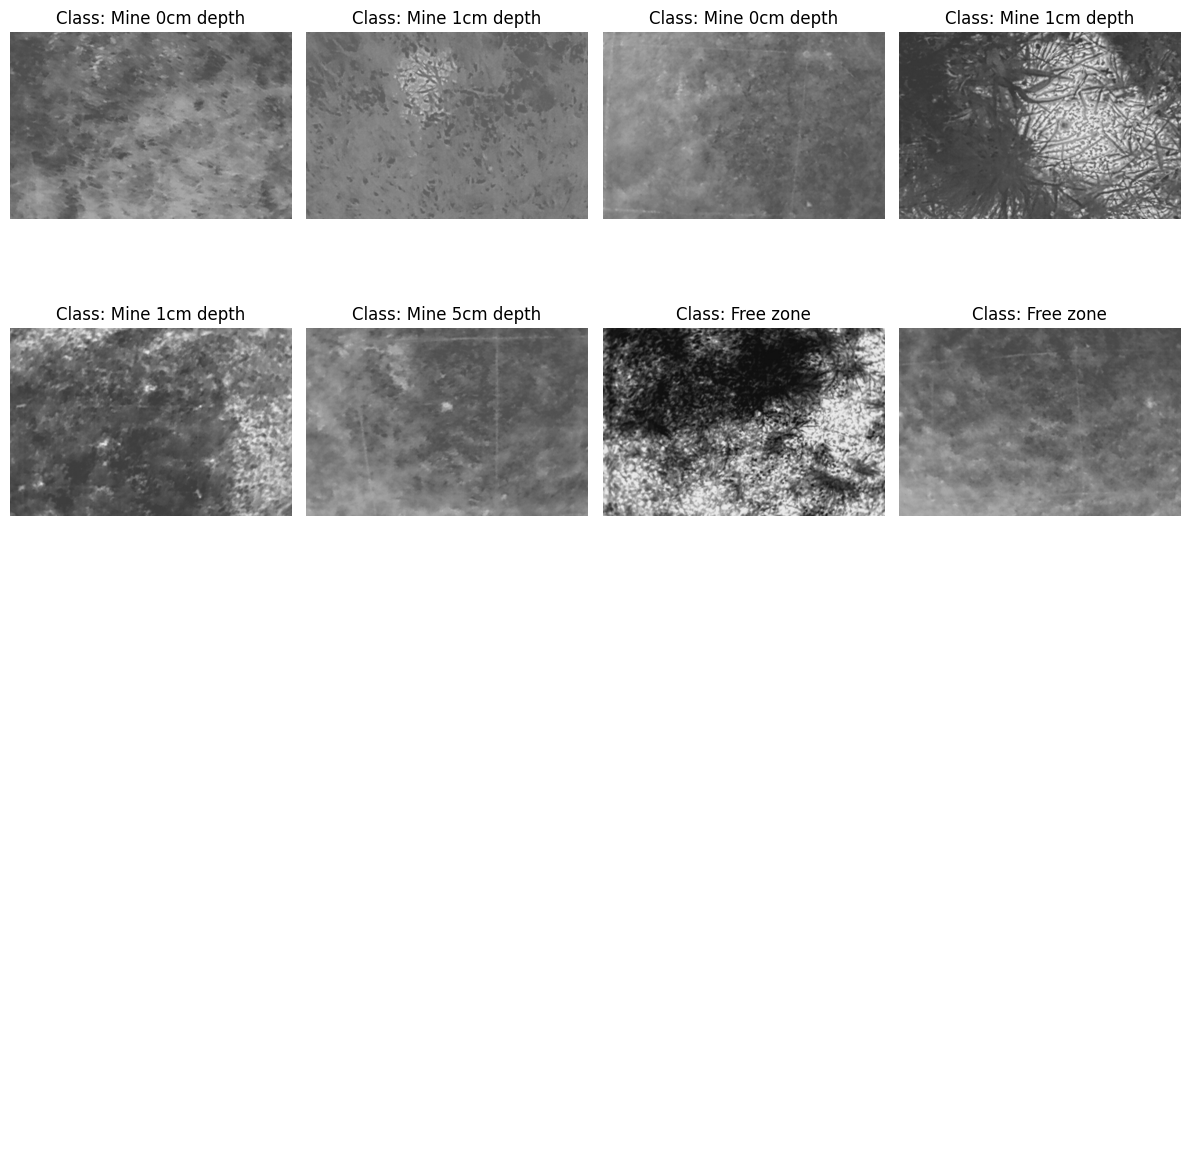

In [14]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(32)

# Paths to train and test datasets
train_data_path = Path(train_data_path_phase_3)
test_data_path = Path(test_data_path_phase_3)

# Get the list of image paths
train_image_path_list = list(train_data_path.glob("*/*.jpg"))
test_image_path_list = list(test_data_path.glob("*/*.jpg"))

print(f"Number of training images: {len(train_image_path_list)}")
print(f"Number of testing images: {len(test_image_path_list)}")

# Select 8 random images
random_image_paths = random.sample(train_image_path_list, 8)

# Create a 4x4 grid (only using the first 8 slots for images)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten axes for easier iteration
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(random_image_paths):  # For the first 8 axes
        image_path = random_image_paths[i]
        img = Image.open(image_path)
        image_class = image_path.parent.stem
        
        ax.imshow(img)
        ax.set_title(f"Class: {image_class}")
        ax.axis('off')
    else:  # Leave remaining slots blank
        ax.axis('off')

plt.tight_layout()
plt.show()


### Classification model
ViT classification model
Through transfer learning, we freeze the rest of the data and keep the head layer learnable.

In [5]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Transfer learning
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
# # Modify the first convolution layer to accept 1-channel (grayscale) input
# pretrained_vit.conv_proj = nn.Conv2d(
#     in_channels=3,  # Grayscale image (1 channel)
#     out_channels=768,  # Output channels
#     kernel_size=16,  # Same kernel size
#     stride=16  # Same stride
# ).to(device)

pretrained_vit.heads = nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features=768, out_features=2)
).to(device)

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

### Dataloader
Prepare the data for training and testing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
 
Class names: ['Free zone', 'Land_mine']
Number of classes: 2
 
Number of training data:  944
Number of testing data:  128
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6109256..1.9254032].


tensor(1)


(-0.5, 223.5, 223.5, -0.5)

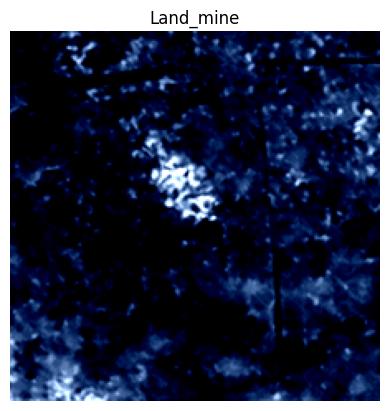

In [10]:
# Main dataset
batch_size = 16
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

# Augmentaed dataset to be added to the main dataset
augmentation_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.RandomHorizontalFlip(p=1),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.3),  # Random vertical flip
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BICUBIC),  # Random rotation
    transforms.Resize(size=256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256
    transforms.CenterCrop(size=224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(
        mean=pretrained_vit_weights.transforms().mean,
        std=pretrained_vit_weights.transforms().std  # Normalize with pretrained weights
    )
])

# Change data here for 2 class, 3 class, and 5 class

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_data_path_phase_1, 
    test_dir=test_data_path_phase_1,
    transform=pretrained_vit_transforms,
    batch_size=batch_size,
    augmentation_transform=augmentation_transform
)


print(' ')
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

print(' ')
print("Number of training data: ", len(train_dataloader_pretrained) * batch_size)
print("Number of testing data: ", len(test_dataloader_pretrained) * batch_size)

# image_batch, label_batch = next(iter(train_dataloader_pretrained))
# print(image_batch.shape, label_batch.shape)

# image, label = image_batch[0], label_batch[0]
# print(image.shape, label)

# plt.imshow(image.permute(1, 2, 0))
# plt.title(class_names[label])
# plt.axis(False)

### Train the model

In [7]:
# Check the device
print(f"Working on device: {device}")

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device
)


Working on device: cuda


  3%|▎         | 1/30 [01:38<47:41, 98.68s/it]

Epoch: 1 | train_loss: 0.3576 | train_acc: 0.8849 | test_loss: 0.3205 | test_acc: 0.8761
class_0_sensitivity: 0.0667
class_0_specificity: 1.0000
class_1_sensitivity: 1.0000
class_1_specificity: 0.0667
weighted_f1_score: 0.8260


  7%|▋         | 2/30 [03:11<44:20, 95.01s/it]

Epoch: 2 | train_loss: 0.2645 | train_acc: 0.9030 | test_loss: 0.2903 | test_acc: 0.8761
class_0_sensitivity: 0.1333
class_0_specificity: 0.9898
class_1_sensitivity: 0.9898
class_1_specificity: 0.1333
weighted_f1_score: 0.8384


e:\Python-codes\Pytorch\packages\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Python-codes\Pytorch\packages\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Python-codes\Pytorch\packages\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 10%|█         |

Epoch: 3 | train_loss: 0.2280 | train_acc: 0.9041 | test_loss: 0.2823 | test_acc: 0.8673
class_0_sensitivity: 0.0000
class_0_specificity: 1.0000
class_1_sensitivity: 1.0000
class_1_specificity: 0.0000
weighted_f1_score: 0.8056


 13%|█▎        | 4/30 [06:17<40:37, 93.76s/it]

Epoch: 4 | train_loss: 0.2117 | train_acc: 0.9190 | test_loss: 0.2962 | test_acc: 0.8761
class_0_sensitivity: 0.3333
class_0_specificity: 0.9592
class_1_sensitivity: 0.9592
class_1_specificity: 0.3333
weighted_f1_score: 0.8625


 17%|█▋        | 5/30 [07:52<39:15, 94.23s/it]

Epoch: 5 | train_loss: 0.1884 | train_acc: 0.9232 | test_loss: 0.2707 | test_acc: 0.8584
class_0_sensitivity: 0.0667
class_0_specificity: 0.9796
class_1_sensitivity: 0.9796
class_1_specificity: 0.0667
weighted_f1_score: 0.8153


 20%|██        | 6/30 [09:26<37:38, 94.10s/it]

Epoch: 6 | train_loss: 0.1841 | train_acc: 0.9307 | test_loss: 0.2796 | test_acc: 0.8673
class_0_sensitivity: 0.2000
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.2000
weighted_f1_score: 0.8417


 23%|██▎       | 7/30 [10:59<35:57, 93.82s/it]

Epoch: 7 | train_loss: 0.1663 | train_acc: 0.9254 | test_loss: 0.2682 | test_acc: 0.8584
class_0_sensitivity: 0.1333
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.1333
weighted_f1_score: 0.8264


 27%|██▋       | 8/30 [12:34<34:28, 94.03s/it]

Epoch: 8 | train_loss: 0.1534 | train_acc: 0.9371 | test_loss: 0.3034 | test_acc: 0.8407
class_0_sensitivity: 0.4000
class_0_specificity: 0.9082
class_1_sensitivity: 0.9082
class_1_specificity: 0.4000
weighted_f1_score: 0.8407


 30%|███       | 9/30 [14:06<32:44, 93.56s/it]

Epoch: 9 | train_loss: 0.1488 | train_acc: 0.9456 | test_loss: 0.2787 | test_acc: 0.8584
class_0_sensitivity: 0.1333
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.1333
weighted_f1_score: 0.8264


 33%|███▎      | 10/30 [15:41<31:20, 94.03s/it]

Epoch: 10 | train_loss: 0.1519 | train_acc: 0.9360 | test_loss: 0.2804 | test_acc: 0.8584
class_0_sensitivity: 0.1333
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.1333
weighted_f1_score: 0.8264


 37%|███▋      | 11/30 [17:27<30:57, 97.75s/it]

Epoch: 11 | train_loss: 0.1533 | train_acc: 0.9414 | test_loss: 0.2771 | test_acc: 0.8673
class_0_sensitivity: 0.1333
class_0_specificity: 0.9796
class_1_sensitivity: 0.9796
class_1_specificity: 0.1333
weighted_f1_score: 0.8324


 40%|████      | 12/30 [19:08<29:33, 98.53s/it]

Epoch: 12 | train_loss: 0.1412 | train_acc: 0.9510 | test_loss: 0.2897 | test_acc: 0.8584
class_0_sensitivity: 0.3333
class_0_specificity: 0.9388
class_1_sensitivity: 0.9388
class_1_specificity: 0.3333
weighted_f1_score: 0.8489


 43%|████▎     | 13/30 [20:44<27:42, 97.78s/it]

Epoch: 13 | train_loss: 0.1475 | train_acc: 0.9520 | test_loss: 0.2753 | test_acc: 0.8761
class_0_sensitivity: 0.1333
class_0_specificity: 0.9898
class_1_sensitivity: 0.9898
class_1_specificity: 0.1333
weighted_f1_score: 0.8384


 47%|████▋     | 14/30 [22:18<25:45, 96.60s/it]

Epoch: 14 | train_loss: 0.1294 | train_acc: 0.9542 | test_loss: 0.2818 | test_acc: 0.8584
class_0_sensitivity: 0.3333
class_0_specificity: 0.9388
class_1_sensitivity: 0.9388
class_1_specificity: 0.3333
weighted_f1_score: 0.8489


 50%|█████     | 15/30 [23:51<23:53, 95.59s/it]

Epoch: 15 | train_loss: 0.1261 | train_acc: 0.9542 | test_loss: 0.2981 | test_acc: 0.8230
class_0_sensitivity: 0.3333
class_0_specificity: 0.8980
class_1_sensitivity: 0.8980
class_1_specificity: 0.3333
weighted_f1_score: 0.8230


 53%|█████▎    | 16/30 [25:24<22:06, 94.79s/it]

Epoch: 16 | train_loss: 0.1441 | train_acc: 0.9467 | test_loss: 0.2752 | test_acc: 0.8673
class_0_sensitivity: 0.2667
class_0_specificity: 0.9592
class_1_sensitivity: 0.9592
class_1_specificity: 0.2667
weighted_f1_score: 0.8493


 57%|█████▋    | 17/30 [26:57<20:27, 94.41s/it]

Epoch: 17 | train_loss: 0.1327 | train_acc: 0.9531 | test_loss: 0.2954 | test_acc: 0.8407
class_0_sensitivity: 0.3333
class_0_specificity: 0.9184
class_1_sensitivity: 0.9184
class_1_specificity: 0.3333
weighted_f1_score: 0.8358


 60%|██████    | 18/30 [28:32<18:55, 94.59s/it]

Epoch: 18 | train_loss: 0.1323 | train_acc: 0.9563 | test_loss: 0.2806 | test_acc: 0.8584
class_0_sensitivity: 0.2667
class_0_specificity: 0.9490
class_1_sensitivity: 0.9490
class_1_specificity: 0.2667
weighted_f1_score: 0.8428


 63%|██████▎   | 19/30 [30:07<17:20, 94.57s/it]

Epoch: 19 | train_loss: 0.1257 | train_acc: 0.9595 | test_loss: 0.3049 | test_acc: 0.8142
class_0_sensitivity: 0.3333
class_0_specificity: 0.8878
class_1_sensitivity: 0.8878
class_1_specificity: 0.3333
weighted_f1_score: 0.8167


 67%|██████▋   | 20/30 [31:43<15:50, 95.01s/it]

Epoch: 20 | train_loss: 0.1257 | train_acc: 0.9542 | test_loss: 0.3065 | test_acc: 0.8407
class_0_sensitivity: 0.3333
class_0_specificity: 0.9184
class_1_sensitivity: 0.9184
class_1_specificity: 0.3333
weighted_f1_score: 0.8358


 70%|███████   | 21/30 [33:25<14:34, 97.15s/it]

Epoch: 21 | train_loss: 0.1221 | train_acc: 0.9456 | test_loss: 0.3177 | test_acc: 0.8053
class_0_sensitivity: 0.3333
class_0_specificity: 0.8776
class_1_sensitivity: 0.8776
class_1_specificity: 0.3333
weighted_f1_score: 0.8104


 73%|███████▎  | 22/30 [35:03<12:58, 97.37s/it]

Epoch: 22 | train_loss: 0.1204 | train_acc: 0.9488 | test_loss: 0.2909 | test_acc: 0.8761
class_0_sensitivity: 0.2667
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.2667
weighted_f1_score: 0.8560


 77%|███████▋  | 23/30 [36:46<11:33, 99.09s/it]

Epoch: 23 | train_loss: 0.1051 | train_acc: 0.9648 | test_loss: 0.2928 | test_acc: 0.8673
class_0_sensitivity: 0.3333
class_0_specificity: 0.9490
class_1_sensitivity: 0.9490
class_1_specificity: 0.3333
weighted_f1_score: 0.8556


 80%|████████  | 24/30 [38:25<09:53, 98.94s/it]

Epoch: 24 | train_loss: 0.1093 | train_acc: 0.9606 | test_loss: 0.2948 | test_acc: 0.8673
class_0_sensitivity: 0.3333
class_0_specificity: 0.9490
class_1_sensitivity: 0.9490
class_1_specificity: 0.3333
weighted_f1_score: 0.8556


 83%|████████▎ | 25/30 [40:03<08:14, 98.88s/it]

Epoch: 25 | train_loss: 0.1244 | train_acc: 0.9552 | test_loss: 0.2684 | test_acc: 0.8584
class_0_sensitivity: 0.1333
class_0_specificity: 0.9694
class_1_sensitivity: 0.9694
class_1_specificity: 0.1333
weighted_f1_score: 0.8264


 87%|████████▋ | 26/30 [41:42<06:35, 98.82s/it]

Epoch: 26 | train_loss: 0.1140 | train_acc: 0.9616 | test_loss: 0.2983 | test_acc: 0.8761
class_0_sensitivity: 0.3333
class_0_specificity: 0.9592
class_1_sensitivity: 0.9592
class_1_specificity: 0.3333
weighted_f1_score: 0.8625


 90%|█████████ | 27/30 [43:15<04:51, 97.09s/it]

Epoch: 27 | train_loss: 0.1177 | train_acc: 0.9584 | test_loss: 0.2838 | test_acc: 0.8584
class_0_sensitivity: 0.2667
class_0_specificity: 0.9490
class_1_sensitivity: 0.9490
class_1_specificity: 0.2667
weighted_f1_score: 0.8428


 93%|█████████▎| 28/30 [44:48<03:11, 95.72s/it]

Epoch: 28 | train_loss: 0.1158 | train_acc: 0.9606 | test_loss: 0.2919 | test_acc: 0.8496
class_0_sensitivity: 0.3333
class_0_specificity: 0.9286
class_1_sensitivity: 0.9286
class_1_specificity: 0.3333
weighted_f1_score: 0.8423


 97%|█████████▋| 29/30 [46:23<01:35, 95.63s/it]

Epoch: 29 | train_loss: 0.1010 | train_acc: 0.9638 | test_loss: 0.2892 | test_acc: 0.8496
class_0_sensitivity: 0.2667
class_0_specificity: 0.9388
class_1_sensitivity: 0.9388
class_1_specificity: 0.2667
weighted_f1_score: 0.8364


100%|██████████| 30/30 [47:57<00:00, 95.93s/it]

Epoch: 30 | train_loss: 0.1008 | train_acc: 0.9659 | test_loss: 0.3100 | test_acc: 0.8319
class_0_sensitivity: 0.3333
class_0_specificity: 0.9082
class_1_sensitivity: 0.9082
class_1_specificity: 0.3333
weighted_f1_score: 0.8294


### Plot model performance

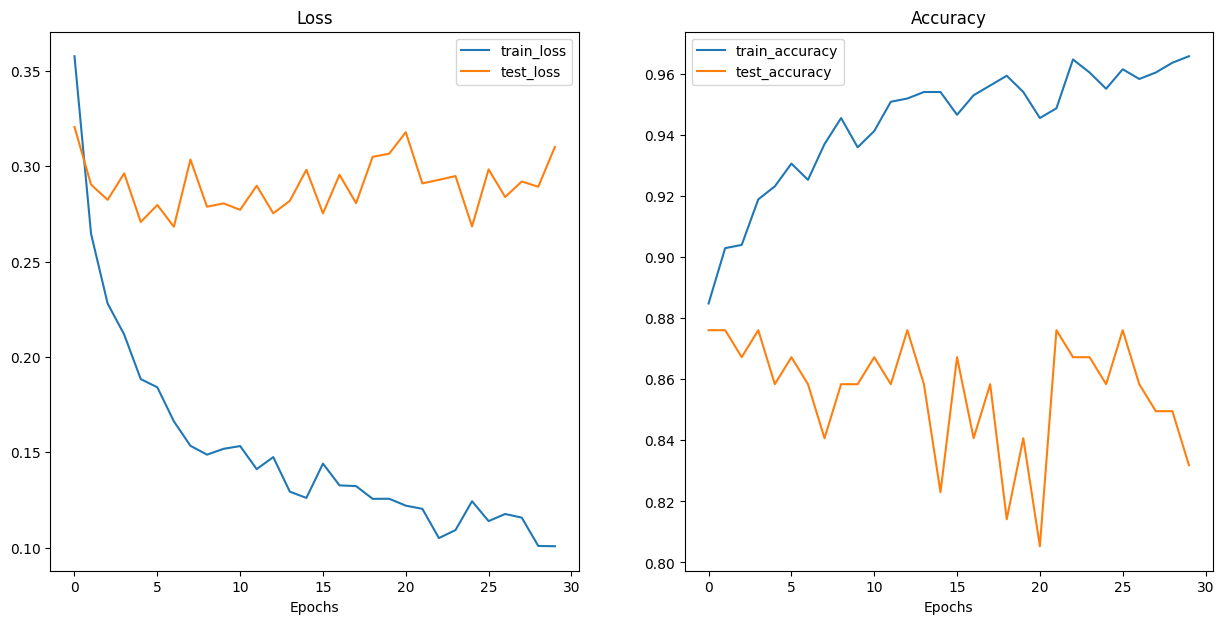

In [8]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Plot ROC curve

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000213A6BB1990>
Traceback (most recent call last):
  File "e:\Python-codes\Pytorch\packages\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "e:\Python-codes\Pytorch\packages\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


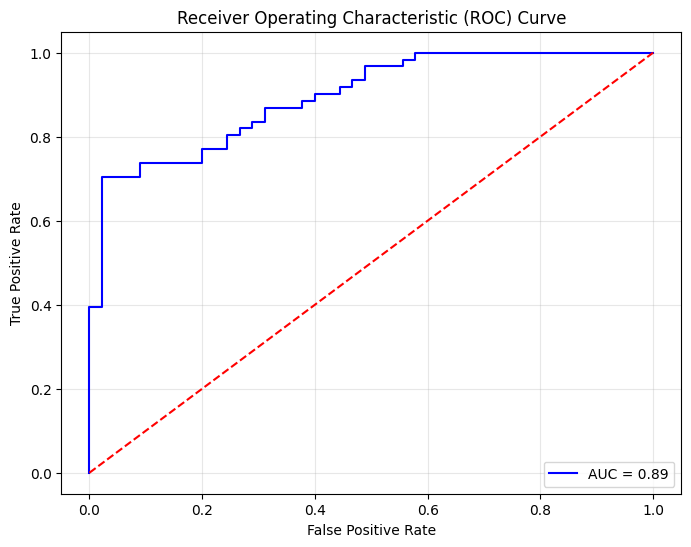

In [30]:
#from helper_functions import plot_roc_auc

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc_auc(model: torch.nn.Module, 
                 dataloader: torch.utils.data.DataLoader, 
                 device: torch.device) -> None:
    """
    Plots the ROC curve and calculates the AUC for a binary classification model.
    
    Parameters:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform computations on (e.g., "cuda" or "cpu").
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_probs = []
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            
            # Convert logits to probabilities
            y_pred_probs = torch.softmax(y_pred_logits, dim=1)[:, 1]  # Probability of class 1
            
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(y_pred_probs.cpu().numpy())
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


plot_roc_auc(model=pretrained_vit, 
             dataloader=test_dataloader_pretrained, 
             device=device)

### Som plots


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6451751..1.9428324].


torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(1)
torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


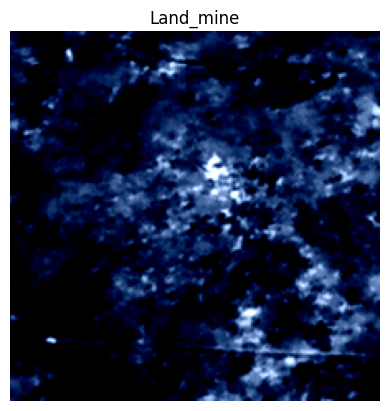

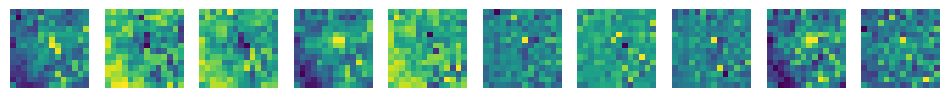

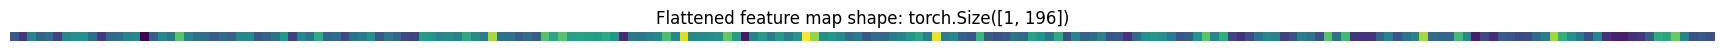

In [11]:
patch_size = 16

image_batch, label_batch = next(iter(train_dataloader_pretrained))
print(image_batch.shape, label_batch.shape)

image, label = image_batch[0], label_batch[0]
print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768, # 3 x 16 x 16 = 768
                   kernel_size=patch_size, 
                   stride=patch_size,
                   padding=0)

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(12, 12))

for i, j in enumerate(range(10)):
    axs[i].imshow(image_out_of_conv[0, j].detach().numpy())
    axs[i].axis(False)


# Create flatten layer
#shape: (1, c, h, w)
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")
#[1, 768, 196] = [batch_size, embedding_dimension, number_of_patches]
#Should reshape to [batch_size, number_of_patches, embedding_dimension]
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);
